In [1]:
import torch.nn.functional as F
from torch import optim
from forestFire import ForestFire
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from actor_critic import ActorCritic
from helper_functions import plot_train_rewards, plot_test_rewards

## Setup replay memory object

In [2]:
class ReplayMemory:
    def __init__(self, size):
        self.buffer = []
        self.max_size = size
        self.oldest_transition = 0

    def sample(self, mb):
        return random.sample(self.buffer, mb)

    def new_transition(self, s, a, r, s_p):
        data = [s, a, r, s_p]
        # Check if buffer is full
        if len(self.buffer) == self.max_size:
            # Replace oldest value in the buffer
            self.buffer[self.oldest_transition] = data
            self.oldest_transition += 1
            if self.oldest_transition == self.max_size:
                self.oldest_transition = 0
        else:
            # Append to the end of buffer
            self.buffer.append(data)

# Create Neural Network for DQN

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ForestFireDQN(nn.Module):
    def __init__(self, input_size):
        super(ForestFireDQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=32),
            nn.ReLU(True),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features=4),
        )


    def forward(self, x):
        x.to(device)
        return self.network(x)

# DQN

## Training DQN on the simple environment

Mean reward after episode 100: -19.0
Mean reward after episode 200: -4.4
Mean reward after episode 300: 10.3
Mean reward after episode 400: 14.2
Mean reward after episode 500: 16.3
Mean reward after episode 600: 20.9
Mean reward after episode 700: 22.4
Mean reward after episode 800: 23.0
Mean reward after episode 900: 24.7
Mean reward after episode 1000: 25.7


<Figure size 640x480 with 0 Axes>

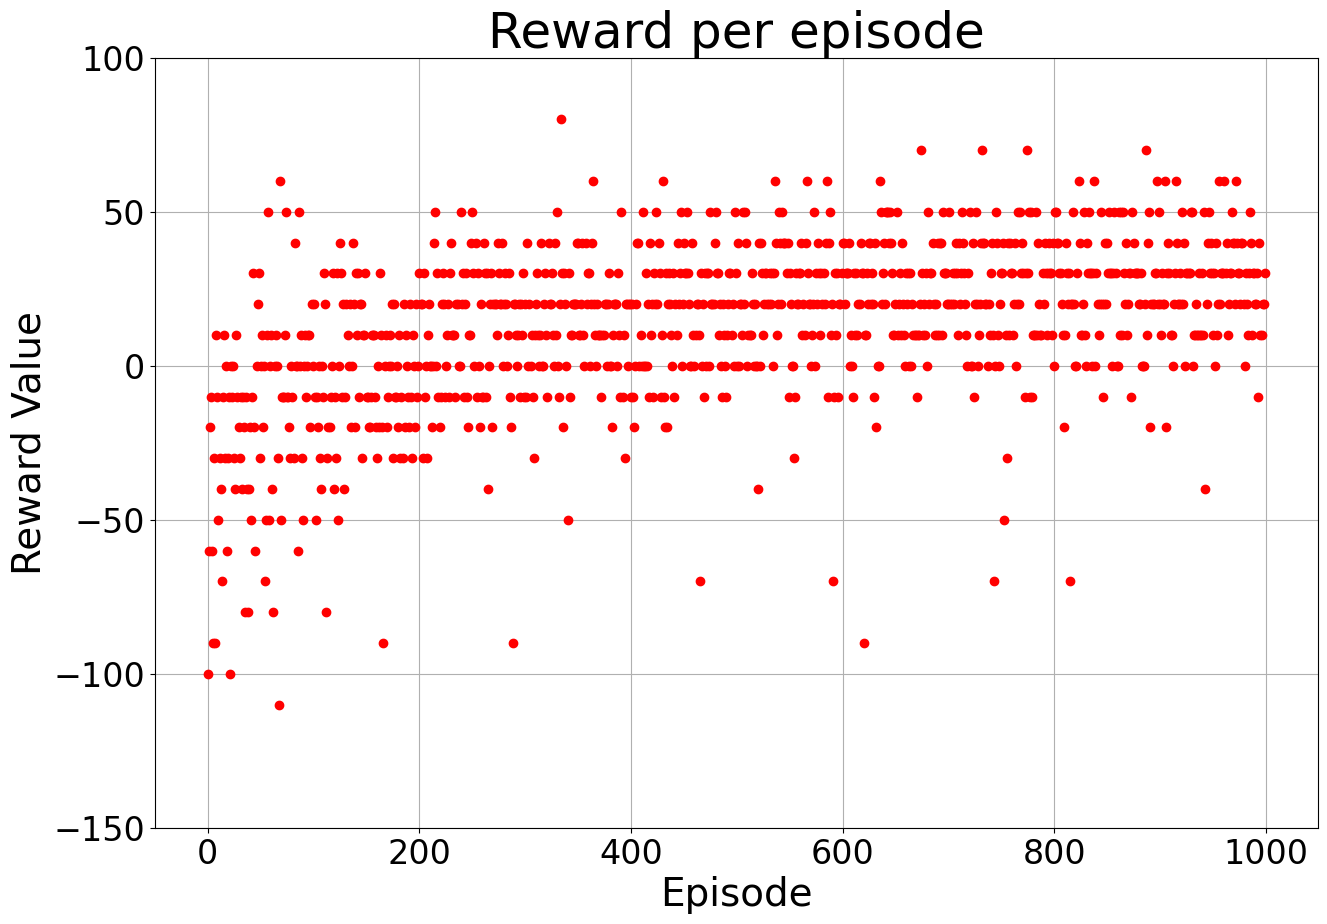

In [43]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, random_fire=False)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(8)
target_policy = ForestFireDQN(8)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
simple_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    simple_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(simple_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Simple', algorithm_name='DQN', episodic_rewards=simple_dqn_total_rewards, ymin=-150, ymax=100, show=True)

# Testing DQN on the simple environment

<Figure size 640x480 with 0 Axes>

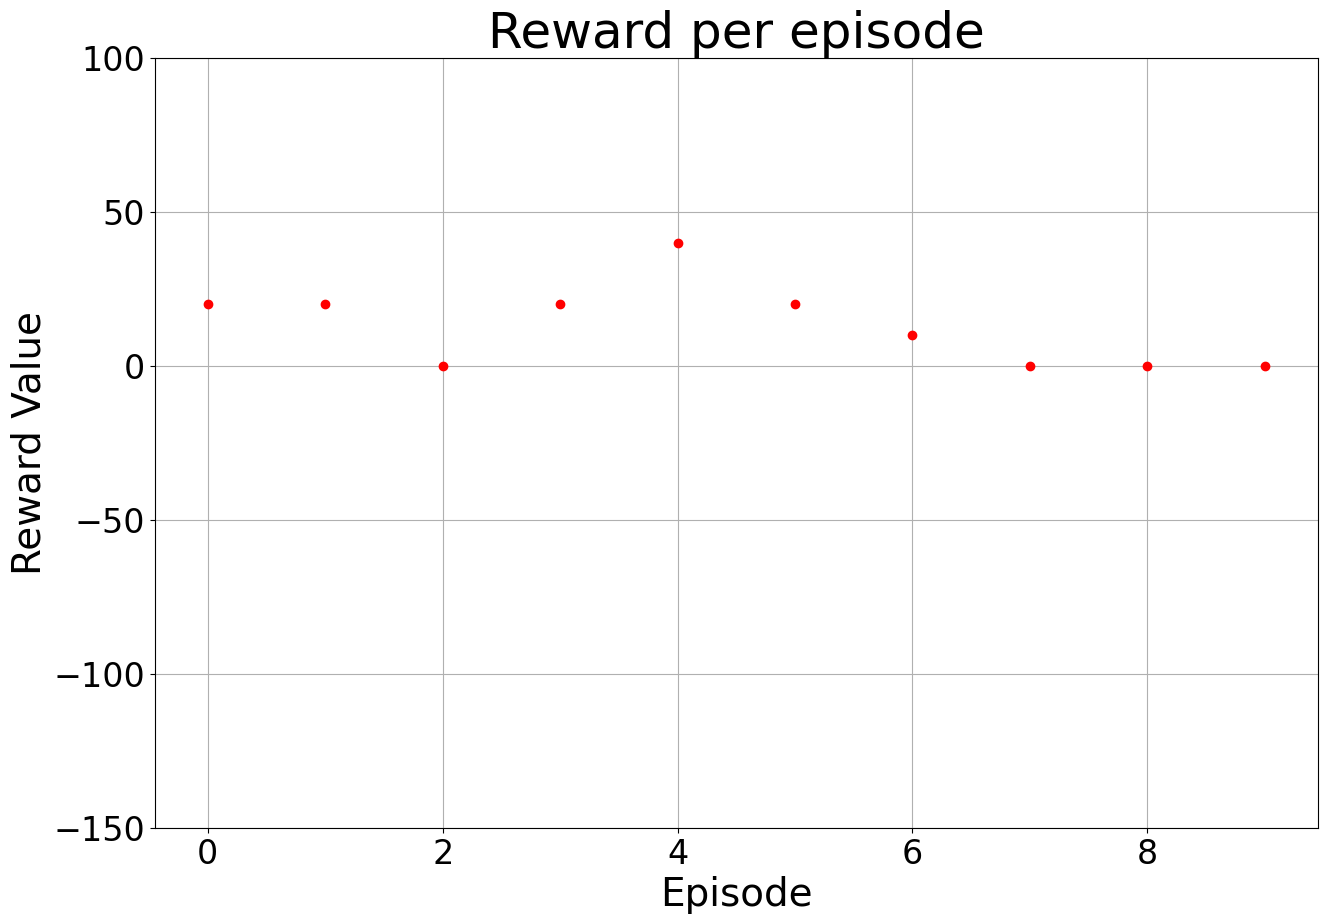

<Figure size 640x480 with 0 Axes>

In [45]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
simple_dqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    simple_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, simple_dqn_test_rewards, min_reward, max_reward, show=True)

## Training DQN on the complex environment


Mean reward after episode 100: -10.7
Mean reward after episode 200: 14.7
Mean reward after episode 300: 33.3
Mean reward after episode 400: 35.0
Mean reward after episode 500: 37.8
Mean reward after episode 600: 45.1
Mean reward after episode 700: 51.7
Mean reward after episode 800: 50.6
Mean reward after episode 900: 51.1
Mean reward after episode 1000: 56.7


<Figure size 640x480 with 0 Axes>

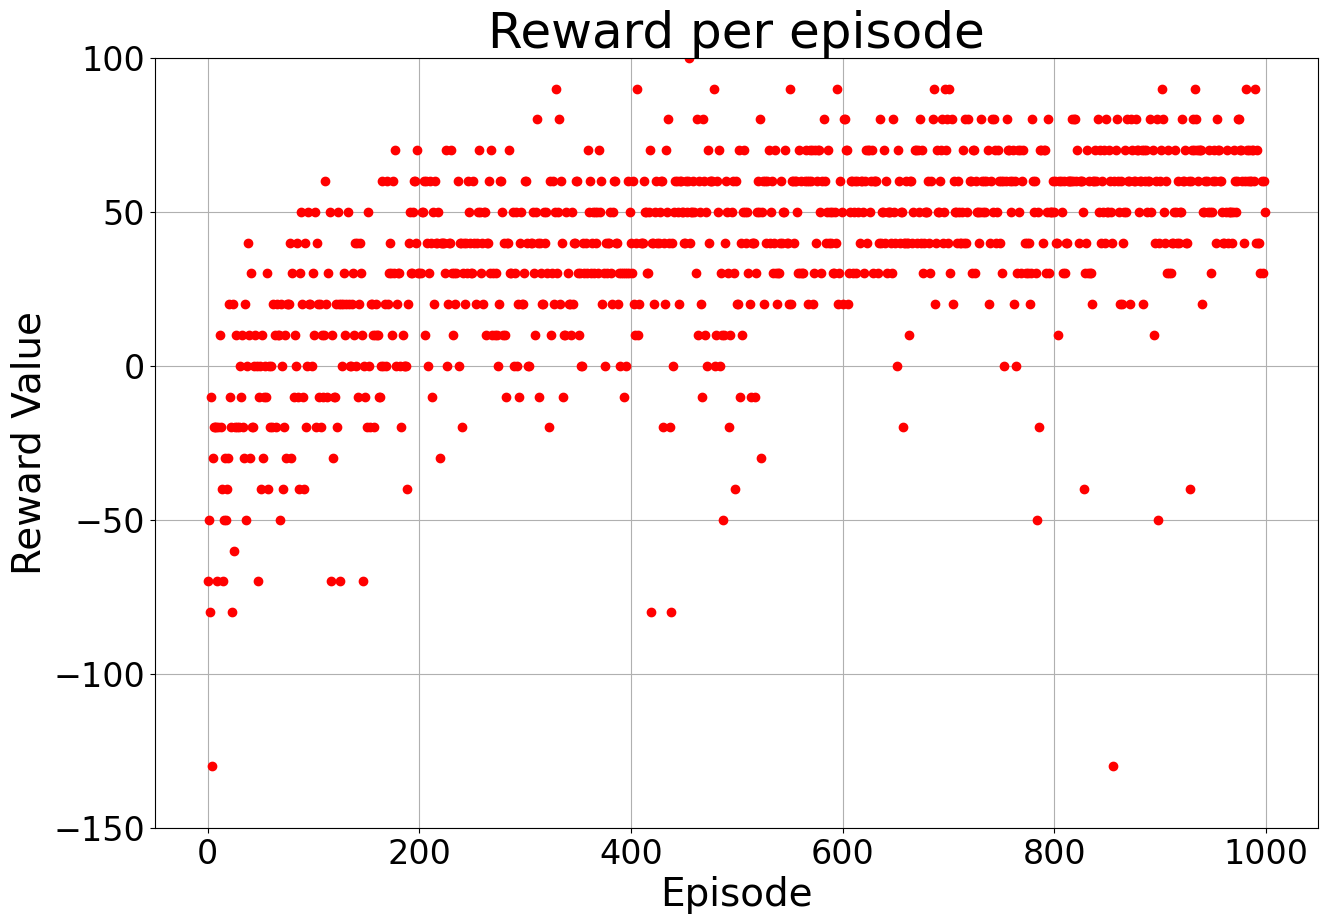

In [46]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
complex_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    complex_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(complex_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex', algorithm_name='DQN', episodic_rewards=complex_dqn_total_rewards, ymin=-150, ymax=100, show=True)

## Test DQN on the complex environment

<Figure size 640x480 with 0 Axes>

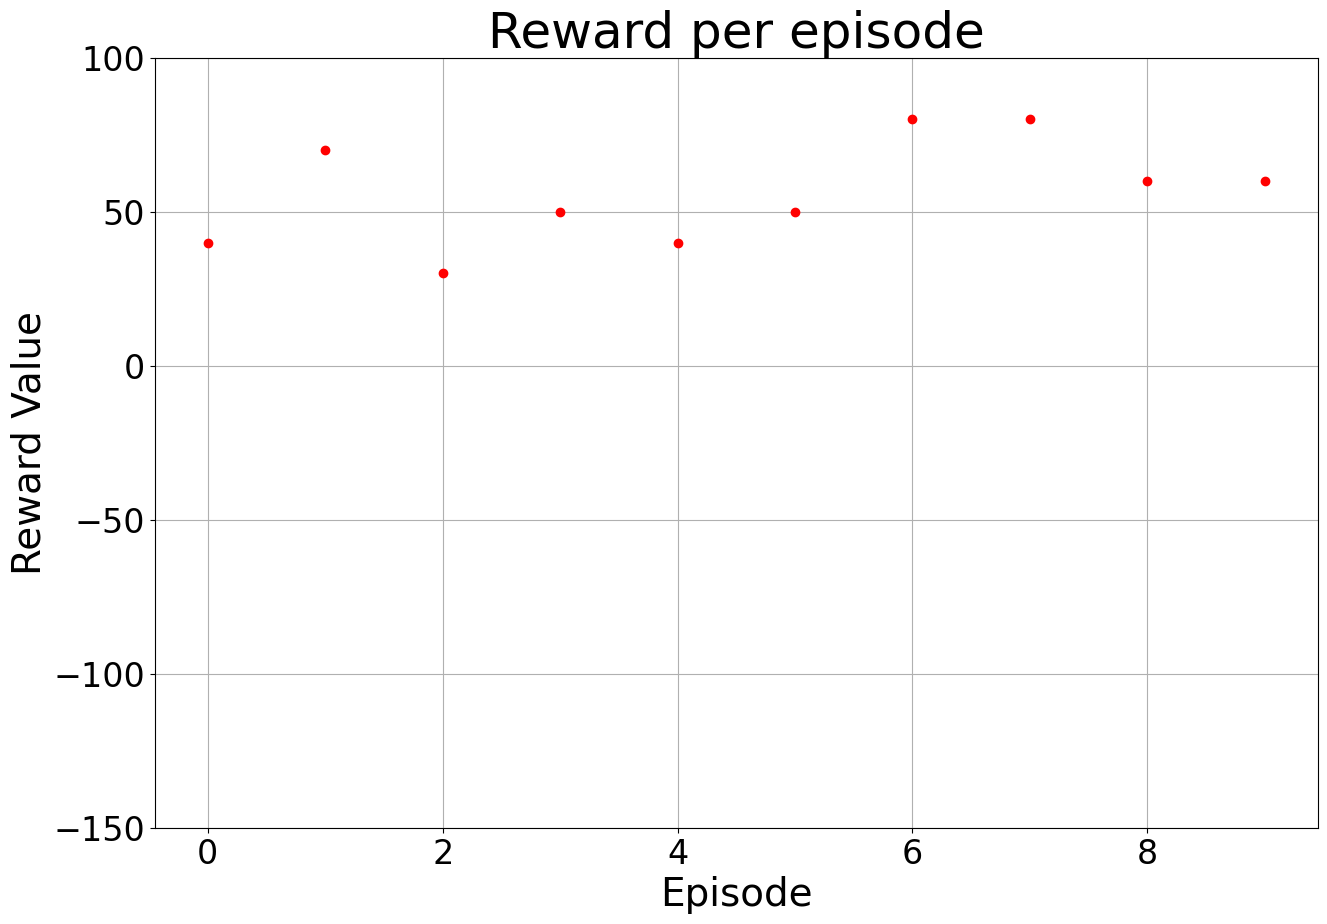

<Figure size 640x480 with 0 Axes>

In [47]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(10, 10, obs_type='complex', save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training DQN on a 10x10 grid and testing on a 15x15 grid


Mean reward after episode 100: -17.5
Mean reward after episode 200: 15.7
Mean reward after episode 300: 37.9
Mean reward after episode 400: 40.1
Mean reward after episode 500: 49.7
Mean reward after episode 600: 49.9
Mean reward after episode 700: 49.3
Mean reward after episode 800: 54.0
Mean reward after episode 900: 51.2
Mean reward after episode 1000: 53.4


<Figure size 640x480 with 0 Axes>

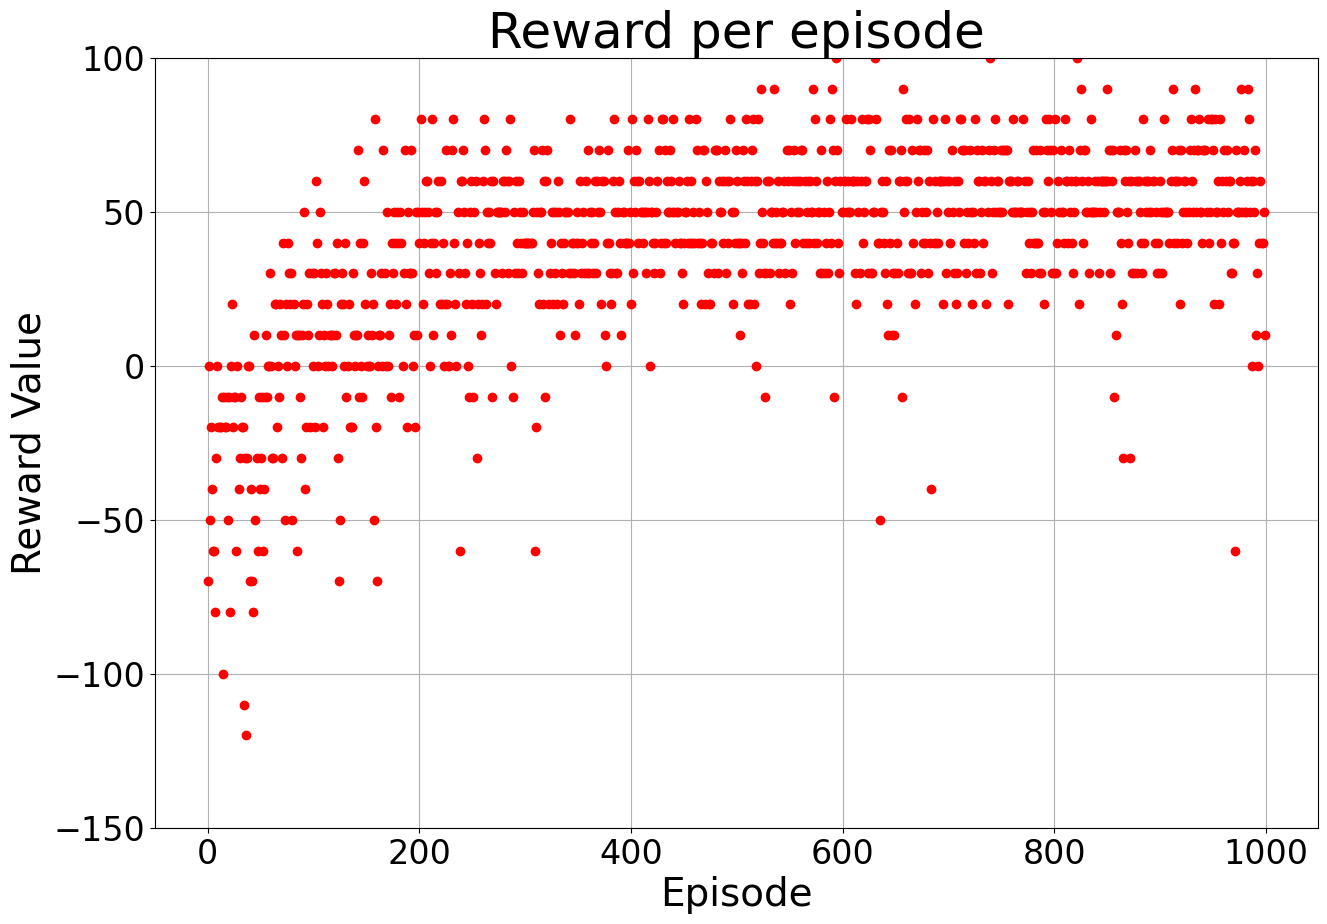

In [48]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
ten_complex_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    ten_complex_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(ten_complex_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex Ten', algorithm_name='DQN', episodic_rewards=ten_complex_dqn_total_rewards, ymin=-150, ymax=100, show=True)

In [ ]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
fifteen_complex_dqn_test_rewards = []
test_env = ForestFire(15, 15, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    fifteen_complex_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, fifteen_complex_dqn_test_rewards, min_reward, max_reward, show=True)

## Training DQN on a 15x15 grid and testing on a 10x10 grid


In [ ]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=15, width=15, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
fifteen_complex_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    fifteen_complex_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(fifteen_complex_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex Fifteen', algorithm_name='DQN', episodic_rewards=fifteen_complex_dqn_total_rewards, ymin=-150, ymax=100, show=True)

In [ ]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
ten_complex_dqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    ten_complex_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, ten_complex_dqn_test_rewards, min_reward, max_reward, show=True)

## Training DQN on the complex environment with random fire


In [ ]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex', random_fire=True)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
random_fire_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    random_fire_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(random_fire_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex Random Fire', algorithm_name='DQN', episodic_rewards=random_fire_dqn_total_rewards, ymin=-150, ymax=100, show=True)

# Double DQN

## Train Double DQN on simple environment

In [ ]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(8)
target_policy = ForestFireDQN(8)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
simple_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    simple_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(simple_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Simple', algorithm_name='Double DQN', episodic_rewards=simple_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

## Test Double DQN on simple environment

In [ ]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
simple_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    simple_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, simple_ddqn_test_rewards, min_reward, max_reward, show=True)

## Train Double DQN on complex environment

In [ ]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
complex_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    complex_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(complex_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Complex', algorithm_name='Double DQN', episodic_rewards=complex_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

## Test Double DQN on complex environment

In [26]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
complex_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    complex_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, complex_ddqn_test_rewards, min_reward, max_reward, show=True)

Mean reward after episode 100: -37.6
Mean reward after episode 200: -44.2
Mean reward after episode 300: -27.4
Mean reward after episode 400: -25.9
Mean reward after episode 500: -14.1
Mean reward after episode 600: -15.2
Mean reward after episode 700: -14.3
Mean reward after episode 800: -1.4
Mean reward after episode 900: 0.4
Mean reward after episode 1000: 2.4
Mean reward after episode 1100: 1.3
Mean reward after episode 1200: -1.0
Mean reward after episode 1300: 1.9
Mean reward after episode 1400: 4.8
Mean reward after episode 1500: 14.0
Mean reward after episode 1600: -0.7
Mean reward after episode 1700: 7.7
Mean reward after episode 1800: 7.7
Mean reward after episode 1900: 9.5
Mean reward after episode 2000: 11.0
Mean reward after episode 2100: 6.8
Mean reward after episode 2200: 17.8
Mean reward after episode 2300: 11.5
Mean reward after episode 2400: 12.5
Mean reward after episode 2500: 12.0
Mean reward after episode 2600: 17.5
Mean reward after episode 2700: 15.9
Mean reward 

## Training the agent on 10x10 grid and testing on 15x15 grid

In [ ]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
ten_complex_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    ten_complex_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(ten_complex_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Ten Complex', algorithm_name='Double DQN', episodic_rewards=ten_complex_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

In [ ]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
fifteen_complex_ddqn_test_rewards = []
test_env = ForestFire(15, 15, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    fifteen_complex_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, fifteen_complex_ddqn_test_rewards, min_reward, max_reward, show=True)

## Training the agent on 15x15 grid and testing on 10x10 grid

In [ ]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=15, width=15, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
fifteen_complex_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    fifteen_complex_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(fifteen_complex_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Ten Complex', algorithm_name='Double DQN', episodic_rewards=fifteen_complex_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

In [ ]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
ten_complex_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    ten_complex_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, ten_complex_ddqn_test_rewards, min_reward, max_reward, show=True)

## Training the agent on complex environment with random fire

In [ ]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex', random_fire=True)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
random_fire_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    random_fire_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(random_fire_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Random Fire Complex', algorithm_name='Double DQN', episodic_rewards=random_fire_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

## Testing the agent on complex environment with random fire

In [ ]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
random_fire_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex', random_fire=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    random_fire_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, random_fire_ddqn_test_rewards, min_reward, max_reward, show=True)

# Actor Critic

## Training agent on simple observation type

Mean reward after episode 0: -10.0
Mean reward after episode 100: -3.9
Mean reward after episode 200: 5.1
Mean reward after episode 300: 15.5
Mean reward after episode 400: 24.6
Mean reward after episode 500: 31.2
Mean reward after episode 600: 35.8
Mean reward after episode 700: 34.6
Mean reward after episode 800: 35.2
Mean reward after episode 900: 28.1
Mean reward after episode 1000: 38.2
Mean reward after episode 1100: 35.9
Mean reward after episode 1200: 36.9
Mean reward after episode 1300: 35.9
Mean reward after episode 1400: 36.6
Mean reward after episode 1500: 36.4
Mean reward after episode 1600: 37.1
Mean reward after episode 1700: 35.5
Mean reward after episode 1800: 35.5
Mean reward after episode 1900: 39.1


<Figure size 640x480 with 0 Axes>

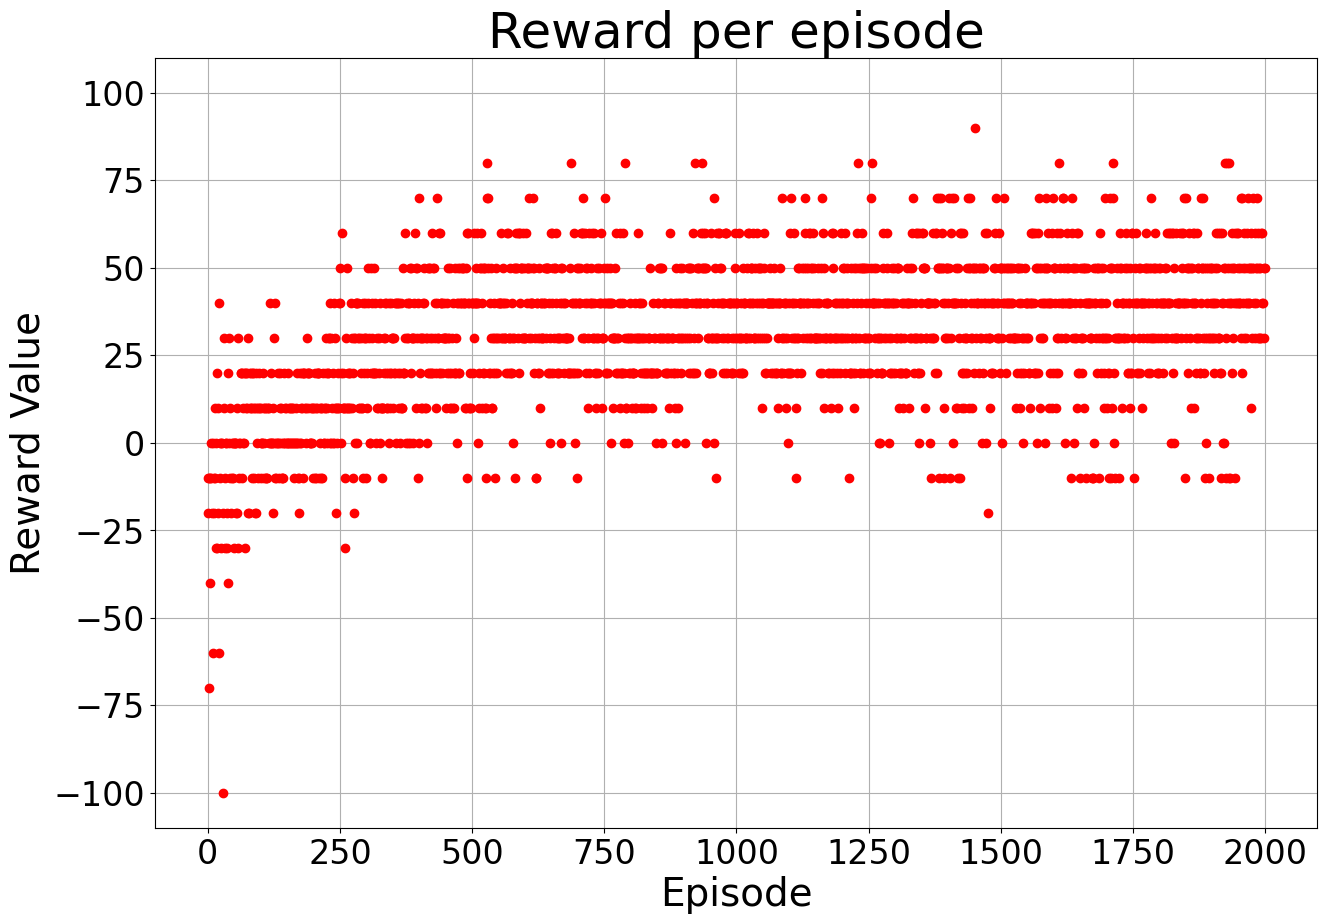

In [19]:
env = ForestFire(height=10, width=10)
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 2000
episodic_rewards = []
environment_name = 'forest_fire'
algorithm_name = 'td_ac'
min_reward = -110
max_reward = 110

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

## Testing agent on simple observation type

Created directory: savedPlots/trial1
30
Created directory: savedPlots/trial2
60
Created directory: savedPlots/trial3
10
Created directory: savedPlots/trial4
40
Created directory: savedPlots/trial5
50
Created directory: savedPlots/trial6
60
Created directory: savedPlots/trial7
40
Created directory: savedPlots/trial8
30
Created directory: savedPlots/trial9
0
Created directory: savedPlots/trial10
40


<Figure size 640x480 with 0 Axes>

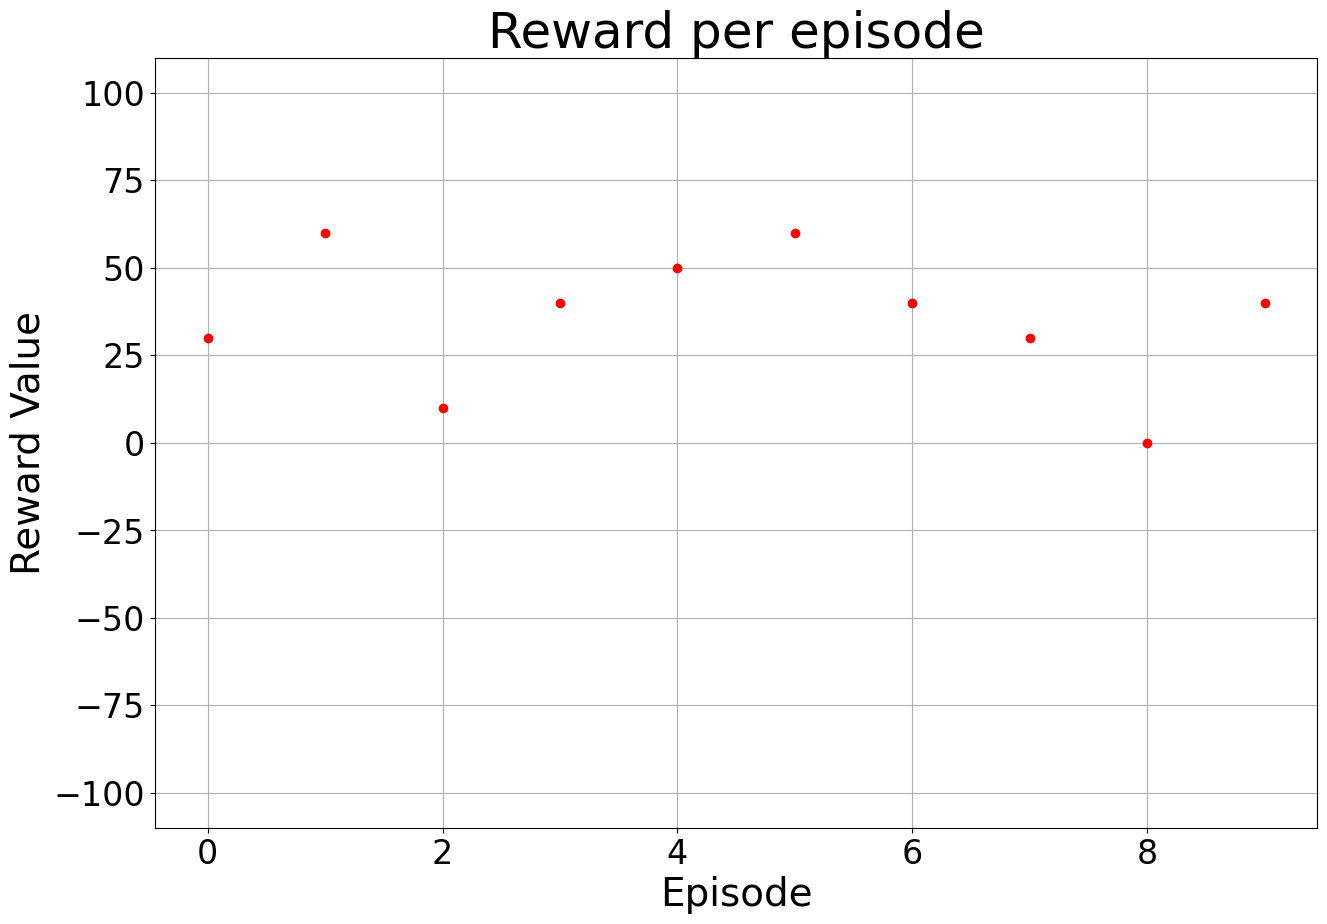

In [21]:
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(height=10, width=10, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
#     render = test_env.render(plot=False)
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
#             render = test_env.render(plot=False)
#     print(reward)
    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training agent on complex observation type

Mean reward after episode 0: 0.0
Mean reward after episode 100: -10.9
Mean reward after episode 200: 20.6
Mean reward after episode 300: 32.1
Mean reward after episode 400: 42.1
Mean reward after episode 500: 48.0
Mean reward after episode 600: 53.6
Mean reward after episode 700: 51.4
Mean reward after episode 800: 52.7
Mean reward after episode 900: 56.1
Mean reward after episode 1000: 54.3
Mean reward after episode 1100: 54.0
Mean reward after episode 1200: 56.9
Mean reward after episode 1300: 59.4
Mean reward after episode 1400: 55.6
Mean reward after episode 1500: 59.1
Mean reward after episode 1600: 55.5
Mean reward after episode 1700: 58.0
Mean reward after episode 1800: 57.4
Mean reward after episode 1900: 58.5


<Figure size 640x480 with 0 Axes>

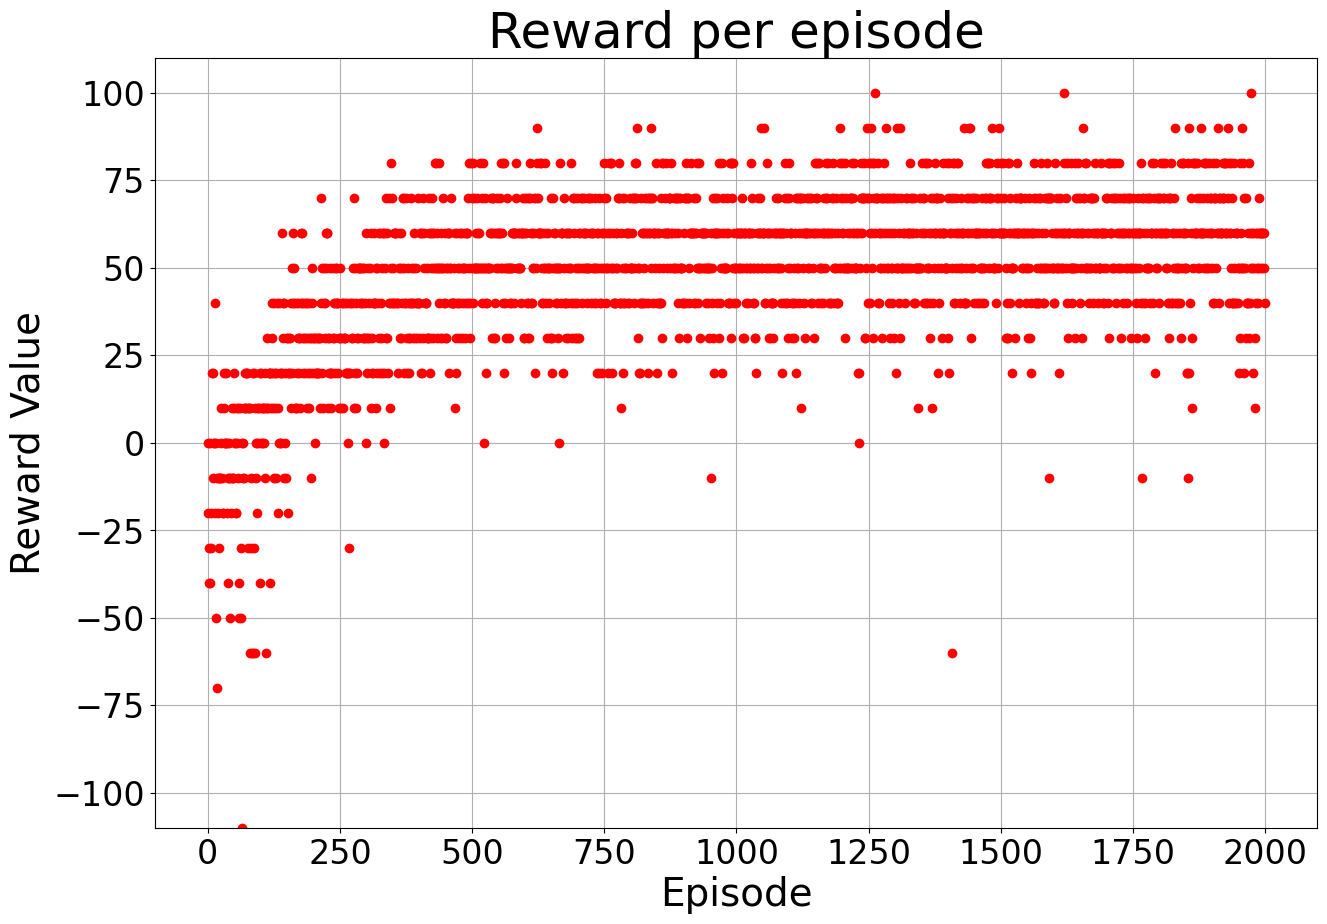

In [17]:
env = ForestFire(height=10, width=10, obs_type='complex')
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 3000
episodic_rewards = []
environment_name = 'forest_fire_complex'
algorithm_name = 'td_ac'
min_reward = -110
max_reward = 110

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

## Testing agent on complex observation type

Created directory: savedPlots/trial1
60
Created directory: savedPlots/trial2
60
Created directory: savedPlots/trial3
50
Created directory: savedPlots/trial4
60
Created directory: savedPlots/trial5
40
Created directory: savedPlots/trial6
70
Created directory: savedPlots/trial7
50
Created directory: savedPlots/trial8
50
Created directory: savedPlots/trial9
70
Created directory: savedPlots/trial10
60


<Figure size 640x480 with 0 Axes>

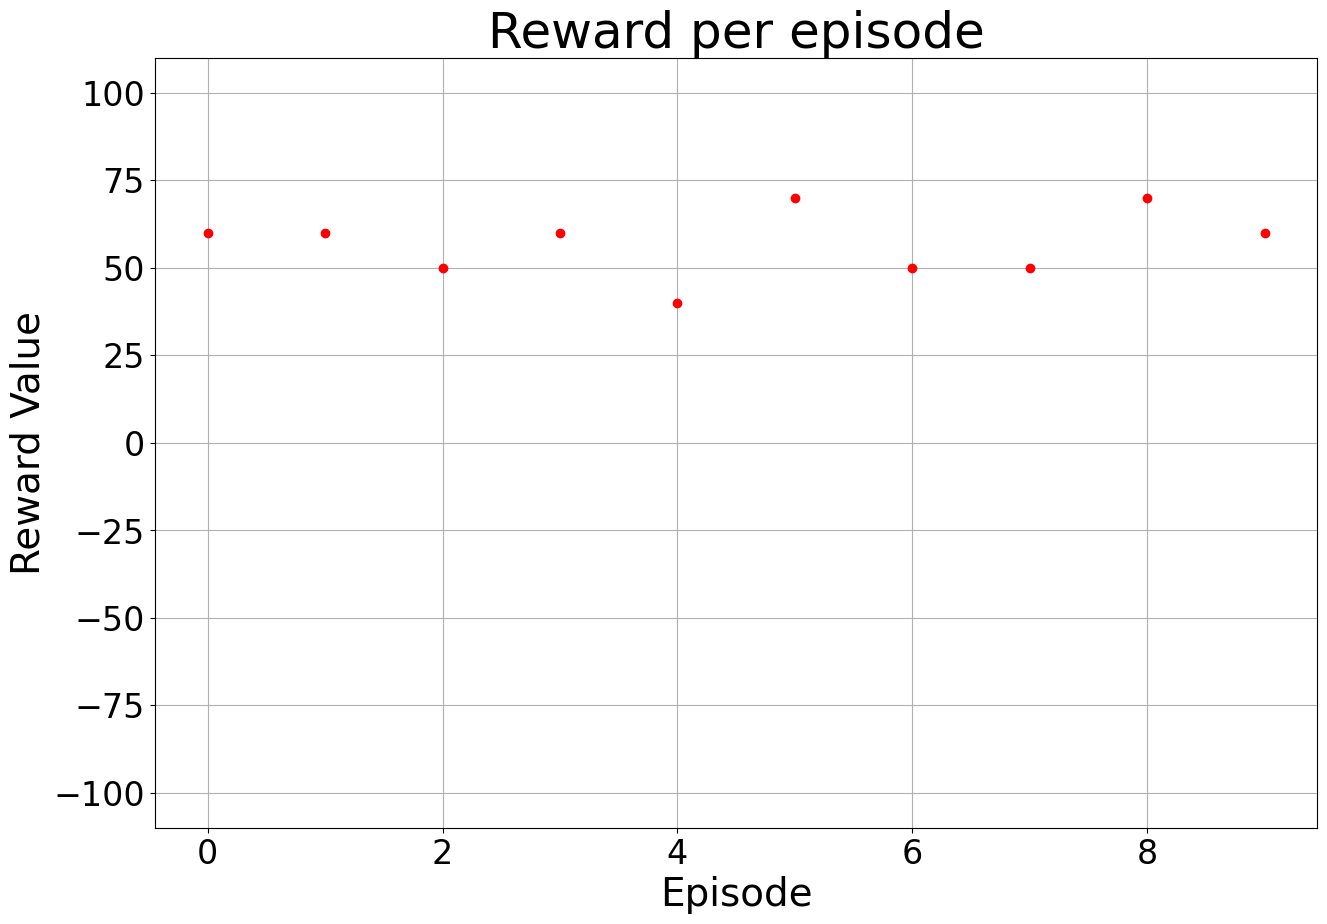

In [18]:
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(height=10, width=10, obs_type='complex', save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
#     render = test_env.render(plot=False)
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
#             render = test_env.render(plot=False)
#     print(reward)
    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Testing the above trained agent on 15x15 environment size

<Figure size 640x480 with 0 Axes>

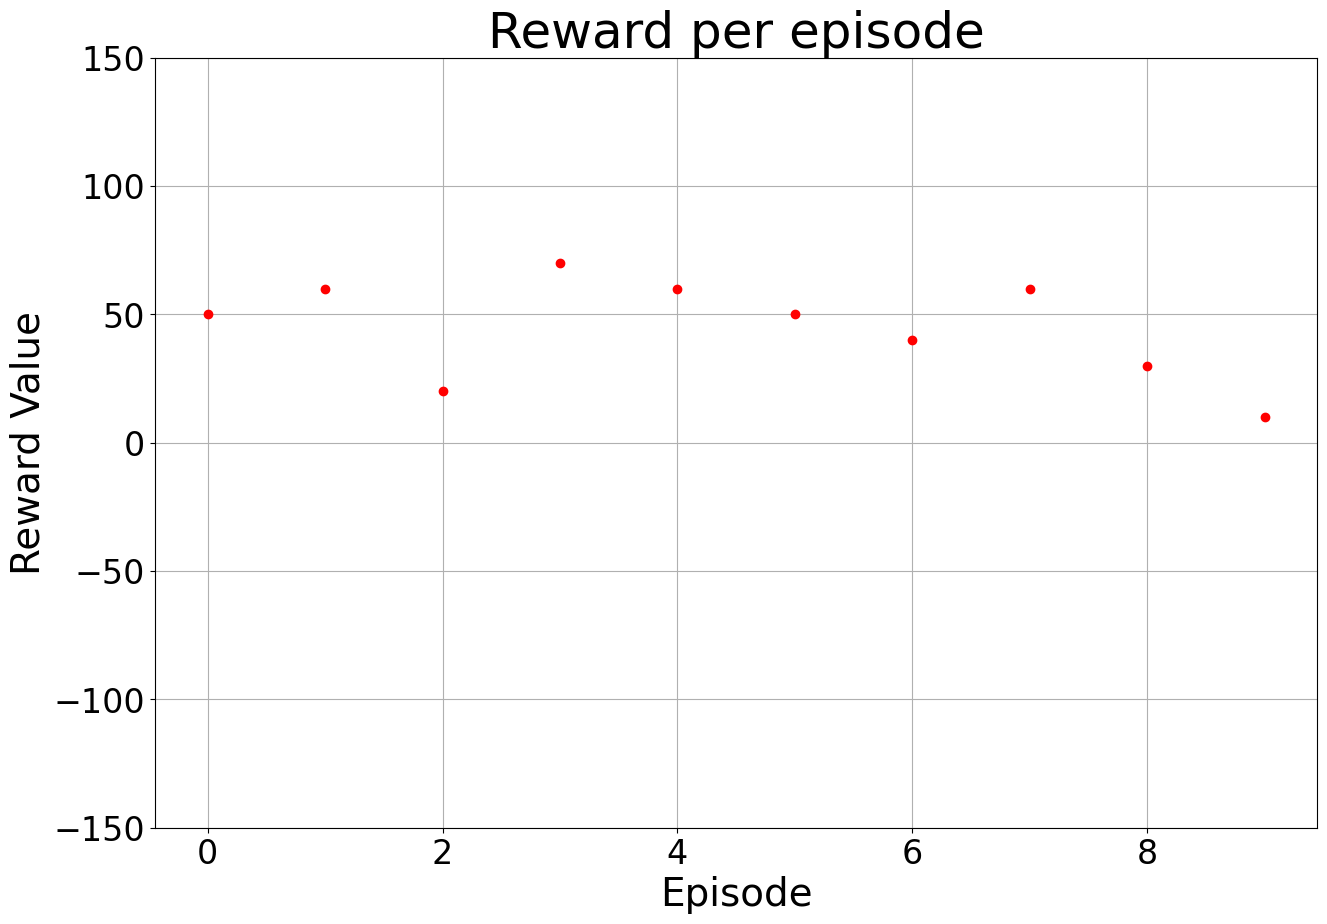

In [8]:
n_episodes_test = 10
test_rewards = []
env = ForestFire(height=15, width=15, obs_type='complex')
min_reward = -150
max_reward = 150
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training the agent on 15x15 environment size

/home/ubansal/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Mean reward after episode 0: -90.0
Mean reward after episode 100: 4.2
Mean reward after episode 200: 35.4
Mean reward after episode 300: 37.9
Mean reward after episode 400: 46.4
Mean reward after episode 500: 49.2
Mean reward after episode 600: 52.8
Mean reward after episode 700: 55.2
Mean reward after episode 800: 53.1
Mean reward after episode 900: 57.3
Mean reward after episode 1000: 49.8
Mean reward after episode 1100: 57.5
Mean reward after episode 1200: 63.8
Mean reward after episode 1300: 53.5
Mean reward after episode 1400: 53.5
Mean reward after episode 1500: 60.8
Mean reward after episode 1600: 48.0
Mean reward after episode 1700: 53.2
Mean reward after episode 1800: 63.4
Mean reward after episode 1900: 59.3
Mean reward after episode 2000: 60.2
Mean reward after episode 2100: 51.4
Mean reward after episode 2200: 53.6
Mean reward after episode 2300: 48.3
Mean reward after episode 2400: 59.7
Mean reward after episode 2500: 65.7
Mean reward after episode 2600: 52.7
Mean reward a

<Figure size 640x480 with 0 Axes>

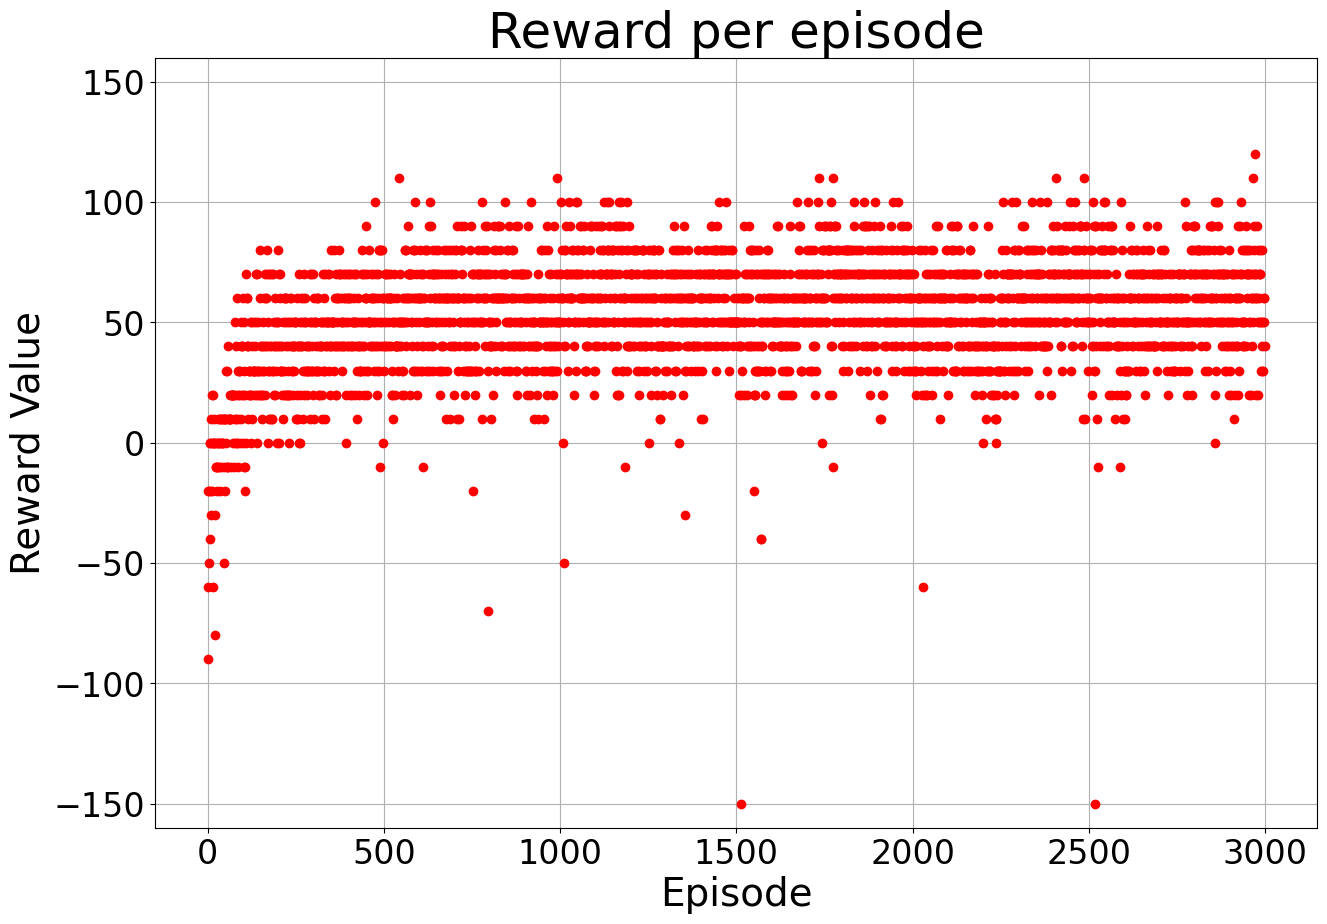

In [2]:
env = ForestFire(height=15, width=15, obs_type='complex')
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True, hidden_units=128)
n_episodes = 3000
episodic_rewards = []
environment_name = 'forest_fire_complex'
algorithm_name = 'td_ac'
min_reward = -160
max_reward = 160

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

## Testing the above trained agent on 10x10 environment size

<Figure size 640x480 with 0 Axes>

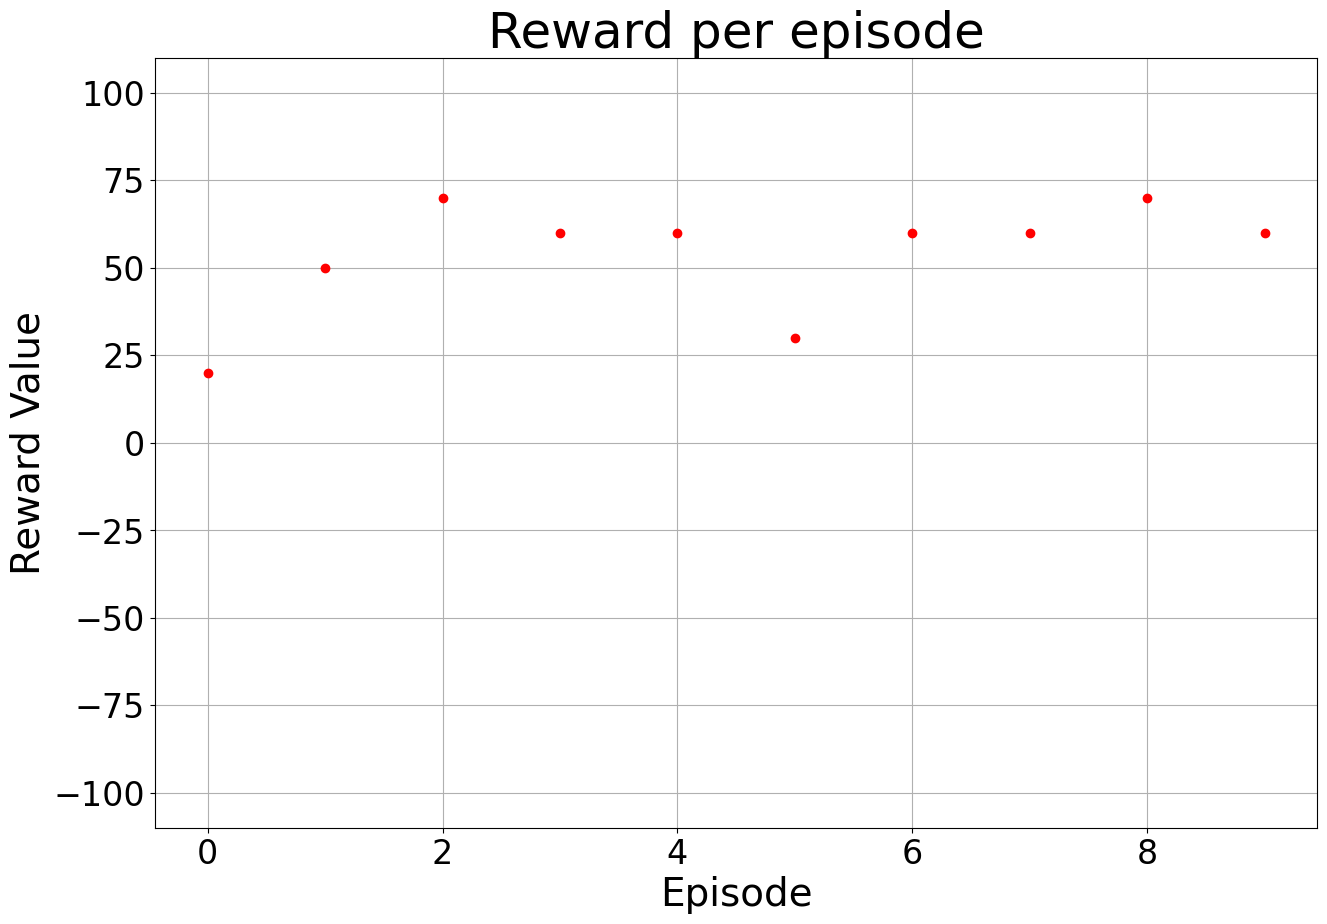

In [5]:
n_episodes_test = 10
test_rewards = []
env = ForestFire(height=10, width=10, obs_type='complex')
min_reward = -110
max_reward = 110
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training the agent on random fire initialization environment

Mean reward after episode 0: -120.0
Mean reward after episode 100: -19.9
Mean reward after episode 200: 2.6
Mean reward after episode 300: 10.2
Mean reward after episode 400: 13.9
Mean reward after episode 500: 12.7
Mean reward after episode 600: 17.5
Mean reward after episode 700: 22.6
Mean reward after episode 800: 20.6
Mean reward after episode 900: 26.5
Mean reward after episode 1000: 29.9
Mean reward after episode 1100: 27.9
Mean reward after episode 1200: 33.0
Mean reward after episode 1300: 38.7
Mean reward after episode 1400: 37.0
Mean reward after episode 1500: 43.4
Mean reward after episode 1600: 39.5
Mean reward after episode 1700: 48.8
Mean reward after episode 1800: 47.1
Mean reward after episode 1900: 46.9
Mean reward after episode 2000: 47.2
Mean reward after episode 2100: 49.4
Mean reward after episode 2200: 45.8
Mean reward after episode 2300: 45.0
Mean reward after episode 2400: 48.1
Mean reward after episode 2500: 47.0
Mean reward after episode 2600: 53.0
Mean reward

<Figure size 640x480 with 0 Axes>

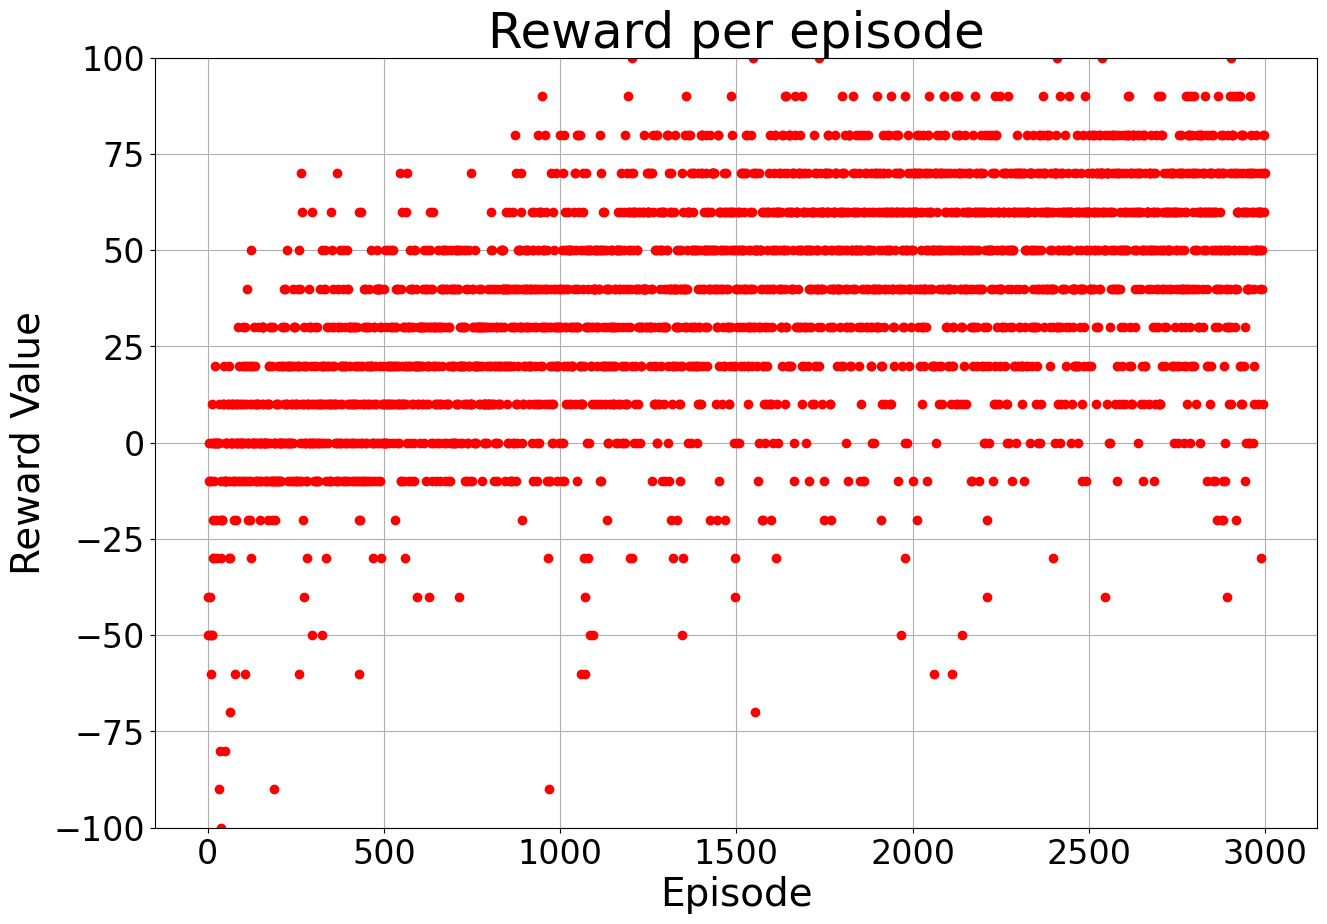

In [6]:
env = ForestFire(height=10, width=10, obs_type='complex', random_fire=True)
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 3000
episodic_rewards = []
environment_name = 'forest_fire_complex_random_fire'
algorithm_name = 'td_ac'
min_reward = -100
max_reward = 100

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

## Testing the agent on random fire initialization environment

<Figure size 640x480 with 0 Axes>

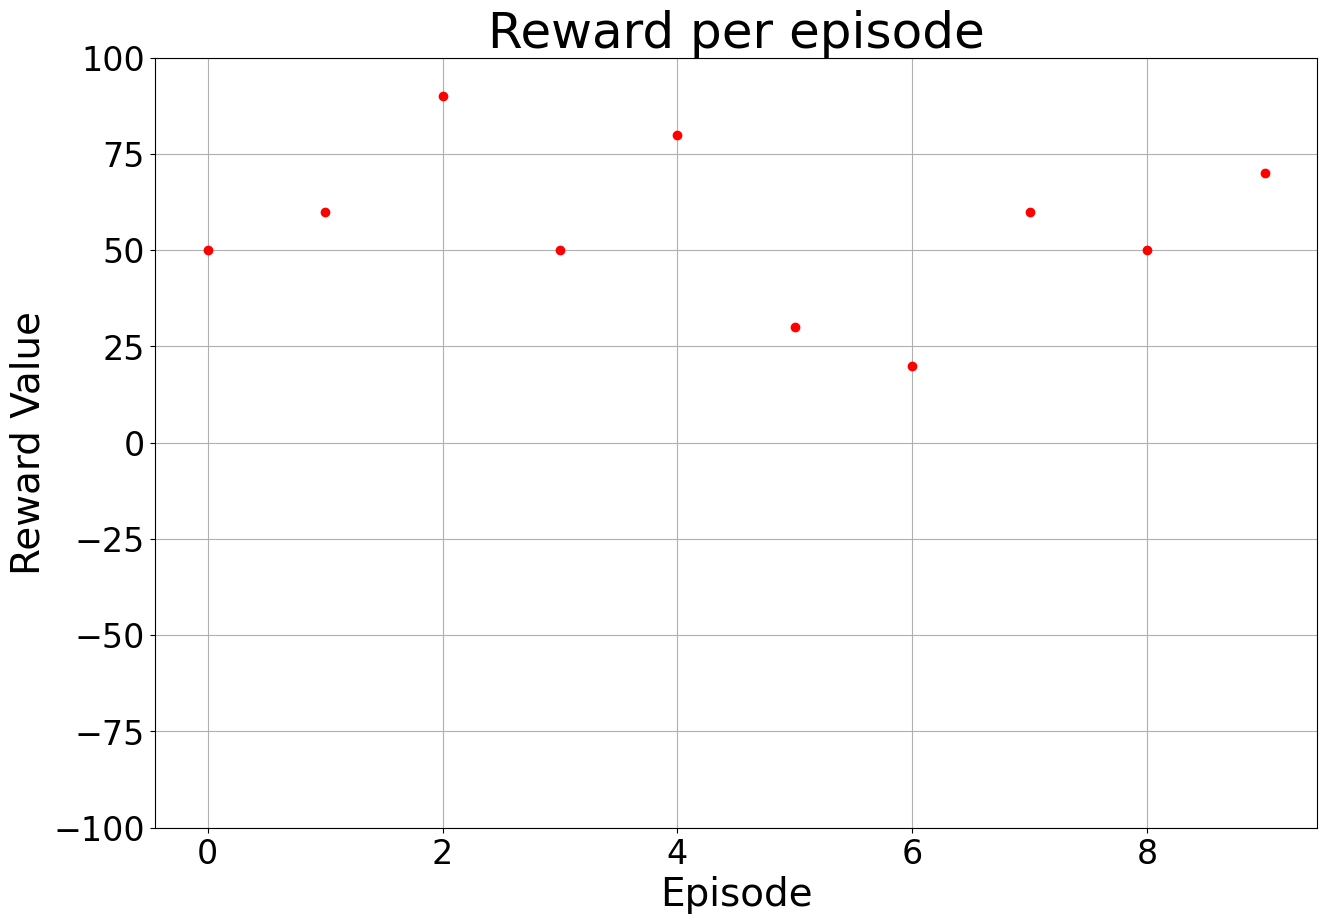

In [9]:
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(height=10, width=10, obs_type='complex', random_fire=True, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
#     render = test_env.render(plot=False)
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
#             render = test_env.render(plot=False)
#     print(reward)
    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)